# Method 3 - Best Ideas Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

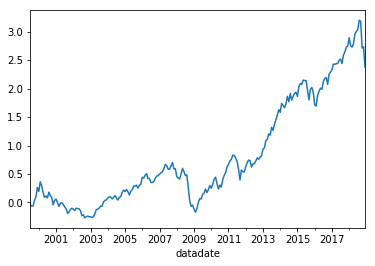

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.265220
2000-12-31   -0.181473
2001-12-31   -0.132180
2002-12-31   -0.166700
2003-12-31    0.397638
2004-12-31    0.162477
2005-12-31    0.085909
2006-12-31    0.112621
2007-12-31    0.083433
2008-12-31   -0.401090
2009-12-31    0.360405
2010-12-31    0.255000
2011-12-31   -0.057680
2012-12-31    0.185170
2013-12-31    0.445320
2014-12-31    0.117098
2015-12-31   -0.000883
2016-12-31    0.120343
2017-12-31    0.140558
2018-12-31   -0.099310
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     530.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.56e-114
Time:                        12:47:41   Log-Likelihood:                 642.50
No. Observations:                 234   AIC:                            -1275.
Df Residuals:                     229   BIC:                            -1258.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.482      0.630      -0.002       0.003
mktrf          0.9959      0.029     34.004      0.000       0.938       1.054
me             0.4359      0.034     12.794      0.000       0.369       0.503
ia            -0.1469      0.052     -2.838      0.005      -0.249      -0.045
roe            0.1550      0.044      3.498      0.001       0.068       0.242
==============================================================================
Omnibus:                       28.365   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.153
Skew:                          -0.108   Prob(JB):                     2.04e-34
Kurtosis:                       6.983   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     403.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.24e-102
Time:                        12:47:41   Log-Likelihood:                 642.50
No. Observations:                 234   AIC:                            -1275.
Df Residuals:                     229   BIC:                            -1258.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.546      0.585      -0.001       0.002
mktrf          0.9959      0.032     30.965      0.000       0.933       1.059
me             0.4359      0.035     12.362      0.000       0.367       0.505
ia            -0.1469      0.094     -1.570      0.116      -0.330       0.036
roe            0.1550      0.055      2.831      0.005       0.048       0.262
==============================================================================
Omnibus:                       28.365   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.153
Skew:                          -0.108   Prob(JB):                     2.04e-34
Kurtosis:                       6.983   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     441.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.48e-106
Time:                        12:47:41   Log-Likelihood:                 642.50
No. Observations:                 234   AIC:                            -1275.
Df Residuals:                     229   BIC:                            -1258.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.562      0.574      -0.001       0.002
mktrf          0.9959      0.028     35.094      0.000       0.940       1.052
me             0.4359      0.032     13.522      0.000       0.373       0.499
ia            -0.1469      0.093     -1.585      0.113      -0.329       0.035
roe            0.1550      0.055      2.823      0.005       0.047       0.263
==============================================================================
Omnibus:                       28.365   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.153
Skew:                          -0.108   Prob(JB):                     2.04e-34
Kurtosis:                       6.983   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     353.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.11e-105
Time:                        12:47:41   Log-Likelihood:                 623.78
No. Observations:                 234   AIC:                            -1236.
Df Residuals:                     228   BIC:                            -1215.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.834      0.405      -0.001       0.003
mktrf          0.9671      0.032     30.353      0.000       0.904       1.030
smb            0.4443      0.042     10.569      0.000       0.361       0.527
hml           -0.0914      0.050     -1.845      0.066      -0.189       0.006
rmw            0.0597      0.056      1.065      0.288      -0.051       0.170
cma           -0.0079      0.071     -0.110      0.912      -0.148       0.133
==============================================================================
Omnibus:                       27.360   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.334
Skew:                          -0.058   Prob(JB):                     1.67e-32
Kurtosis:                       6.872   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     321.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.19e-101
Time:                        12:47:41   Log-Likelihood:                 623.78
No. Observations:                 234   AIC:                            -1236.
Df Residuals:                     228   BIC:                            -1215.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.877      0.380      -0.001       0.003
mktrf          0.9671      0.042     23.014      0.000       0.885       1.049
smb            0.4443      0.059      7.473      0.000       0.328       0.561
hml           -0.0914      0.086     -1.058      0.290      -0.261       0.078
rmw            0.0597      0.093      0.643      0.520      -0.122       0.242
cma           -0.0079      0.148     -0.053      0.958      -0.298       0.283
==============================================================================
Omnibus:                       27.360   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.334
Skew:                          -0.058   Prob(JB):                     1.67e-32
Kurtosis:                       6.872   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     381.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.39e-108
Time:                        12:47:41   Log-Likelihood:                 623.78
No. Observations:                 234   AIC:                            -1236.
Df Residuals:                     228   BIC:                            -1215.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.936      0.349      -0.001       0.003
mktrf          0.9671      0.042     22.786      0.000       0.884       1.050
smb            0.4443      0.059      7.544      0.000       0.329       0.560
hml           -0.0914      0.088     -1.037      0.300      -0.264       0.081
rmw            0.0597      0.098      0.607      0.544      -0.133       0.253
cma           -0.0079      0.153     -0.051      0.959      -0.307       0.292
==============================================================================
Omnibus:                       27.360   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.334
Skew:                          -0.058   Prob(JB):                     1.67e-32
Kurtosis:                       6.872   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     514.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.57e-113
Time:                        12:47:41   Log-Likelihood:                 639.30
No. Observations:                 234   AIC:                            -1269.
Df Residuals:                     229   BIC:                            -1251.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.429      0.668      -0.002       0.003
mktrf          1.0294      0.027     37.657      0.000       0.976       1.083
smb            0.3430      0.034     10.053      0.000       0.276       0.410
hml            0.0395      0.034      1.166      0.245      -0.027       0.106
umd            0.1457      0.022      6.553      0.000       0.102       0.190
==============================================================================
Omnibus:                       57.847   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.927
Skew:                          -0.698   Prob(JB):                     6.60e-97
Kurtosis:                       9.594   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     425.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.18e-105
Time:                        12:47:41   Log-Likelihood:                 639.30
No. Observations:                 234   AIC:                            -1269.
Df Residuals:                     229   BIC:                            -1251.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.489      0.625      -0.001       0.002
mktrf          1.0294      0.037     28.055      0.000       0.958       1.101
smb            0.3430      0.044      7.885      0.000       0.258       0.428
hml            0.0395      0.056      0.711      0.477      -0.070       0.149
umd            0.1457      0.045      3.219      0.001       0.057       0.234
==============================================================================
Omnibus:                       57.847   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.927
Skew:                          -0.698   Prob(JB):                     6.60e-97
Kurtosis:                       9.594   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     562.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.91e-117
Time:                        12:47:41   Log-Likelihood:                 639.30
No. Observations:                 234   AIC:                            -1269.
Df Residuals:                     229   BIC:                            -1251.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.529      0.597      -0.001       0.002
mktrf          1.0294      0.034     30.307      0.000       0.963       1.096
smb            0.3430      0.045      7.606      0.000       0.255       0.431
hml            0.0395      0.054      0.728      0.466      -0.067       0.146
umd            0.1457      0.039      3.700      0.000       0.069       0.223
==============================================================================
Omnibus:                       57.847   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.927
Skew:                          -0.698   Prob(JB):                     6.60e-97
Kurtosis:                       9.594   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     208.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.44e-52
Time:                        12:47:41   Log-Likelihood:                 303.69
No. Observations:                 120   AIC:                            -597.4
Df Residuals:                     115   BIC:                            -583.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.002      0.064      0.949      -0.004       0.004
mktrf          1.0266      0.051     20.243      0.000       0.926       1.127
me             0.4523      0.050      9.030      0.000       0.353       0.552
ia            -0.1994      0.078     -2.542      0.012      -0.355      -0.044
roe            0.2534      0.069      3.651      0.000       0.116       0.391
==============================================================================
Omnibus:                       12.005   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               30.781
Skew:                          -0.203   Prob(JB):                     2.07e-07
Kurtosis:                       5.448   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     190.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.00e-50
Time:                        12:47:41   Log-Likelihood:                 303.69
No. Observations:                 120   AIC:                            -597.4
Df Residuals:                     115   BIC:                            -583.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.081      0.935      -0.003       0.003
mktrf          1.0266      0.054     19.128      0.000       0.921       1.132
me             0.4523      0.046      9.761      0.000       0.362       0.543
ia            -0.1994      0.121     -1.646      0.100      -0.437       0.038
roe            0.2534      0.069      3.664      0.000       0.118       0.389
==============================================================================
Omnibus:                       12.005   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               30.781
Skew:                          -0.203   Prob(JB):                     2.07e-07
Kurtosis:                       5.448   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     199.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.60e-51
Time:                        12:47:41   Log-Likelihood:                 303.69
No. Observations:                 120   AIC:                            -597.4
Df Residuals:                     115   BIC:                            -583.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.086      0.931      -0.003       0.003
mktrf          1.0266      0.042     24.243      0.000       0.944       1.110
me             0.4523      0.044     10.381      0.000       0.367       0.538
ia            -0.1994      0.119     -1.678      0.093      -0.432       0.034
roe            0.2534      0.053      4.823      0.000       0.150       0.356
==============================================================================
Omnibus:                       12.005   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               30.781
Skew:                          -0.203   Prob(JB):                     2.07e-07
Kurtosis:                       5.448   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     127.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.06e-45
Time:                        12:47:41   Log-Likelihood:                 290.20
No. Observations:                 120   AIC:                            -568.4
Df Residuals:                     114   BIC:                            -551.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.617      0.539      -0.003       0.006
mktrf          0.9827      0.060     16.352      0.000       0.864       1.102
smb            0.4630      0.068      6.802      0.000       0.328       0.598
hml           -0.1509      0.083     -1.809      0.073      -0.316       0.014
rmw            0.1381      0.098      1.405      0.163      -0.057       0.333
cma            0.0161      0.108      0.150      0.881      -0.197       0.230
==============================================================================
Omnibus:                        8.793   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               18.537
Skew:                          -0.094   Prob(JB):                     9.44e-05
Kurtosis:                       4.916   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     156.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.61e-49
Time:                        12:47:41   Log-Likelihood:                 290.20
No. Observations:                 120   AIC:                            -568.4
Df Residuals:                     114   BIC:                            -551.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.719      0.472      -0.002       0.005
mktrf          0.9827      0.083     11.795      0.000       0.819       1.146
smb            0.4630      0.089      5.194      0.000       0.288       0.638
hml           -0.1509      0.132     -1.142      0.253      -0.410       0.108
rmw            0.1381      0.160      0.866      0.387      -0.175       0.451
cma            0.0161      0.188      0.086      0.932      -0.352       0.385
==============================================================================
Omnibus:                        8.793   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               18.537
Skew:                          -0.094   Prob(JB):                     9.44e-05
Kurtosis:                       4.916   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     154.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.74e-49
Time:                        12:47:41   Log-Likelihood:                 290.20
No. Observations:                 120   AIC:                            -568.4
Df Residuals:                     114   BIC:                            -551.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.769      0.442      -0.002       0.005
mktrf          0.9827      0.088     11.223      0.000       0.811       1.154
smb            0.4630      0.090      5.136      0.000       0.286       0.640
hml           -0.1509      0.139     -1.090      0.276      -0.422       0.121
rmw            0.1381      0.175      0.787      0.431      -0.206       0.482
cma            0.0161      0.192      0.084      0.933      -0.359       0.392
==============================================================================
Omnibus:                        8.793   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               18.537
Skew:                          -0.094   Prob(JB):                     9.44e-05
Kurtosis:                       4.916   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     202.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.47e-51
Time:                        12:47:41   Log-Likelihood:                 302.06
No. Observations:                 120   AIC:                            -594.1
Df Residuals:                     115   BIC:                            -580.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.953      0.343      -0.002       0.005
mktrf          1.0619      0.045     23.447      0.000       0.972       1.152
smb            0.2955      0.052      5.730      0.000       0.193       0.398
hml            0.0293      0.052      0.567      0.572      -0.073       0.132
umd            0.1816      0.032      5.703      0.000       0.119       0.245
==============================================================================
Omnibus:                       35.236   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.512
Skew:                          -0.904   Prob(JB):                     4.17e-32
Kurtosis:                       8.063   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     224.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.45e-53
Time:                        12:47:41   Log-Likelihood:                 302.06
No. Observations:                 120   AIC:                            -594.1
Df Residuals:                     115   BIC:                            -580.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.205      0.228      -0.001       0.005
mktrf          1.0619      0.054     19.796      0.000       0.957       1.167
smb            0.2955      0.051      5.775      0.000       0.195       0.396
hml            0.0293      0.067      0.439      0.660      -0.101       0.160
umd            0.1816      0.057      3.211      0.001       0.071       0.292
==============================================================================
Omnibus:                       35.236   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.512
Skew:                          -0.904   Prob(JB):                     4.17e-32
Kurtosis:                       8.063   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     313.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.79e-61
Time:                        12:47:41   Log-Likelihood:                 302.06
No. Observations:                 120   AIC:                            -594.1
Df Residuals:                     115   BIC:                            -580.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.310      0.190      -0.001       0.004
mktrf          1.0619      0.046     23.224      0.000       0.972       1.151
smb            0.2955      0.047      6.266      0.000       0.203       0.388
hml            0.0293      0.061      0.478      0.633      -0.091       0.149
umd            0.1816      0.044      4.135      0.000       0.096       0.268
==============================================================================
Omnibus:                       35.236   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.512
Skew:                          -0.904   Prob(JB):                     4.17e-32
Kurtosis:                       8.063   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     608.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.47e-73
Time:                        12:47:41   Log-Likelihood:                 377.47
No. Observations:                 114   AIC:                            -744.9
Df Residuals:                     109   BIC:                            -731.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.373      0.172      -0.001       0.003
mktrf          0.9760      0.027     36.779      0.000       0.923       1.029
me             0.3926      0.041      9.582      0.000       0.311       0.474
ia            -0.1128      0.057     -1.984      0.050      -0.225      -0.000
roe           -0.0983      0.050     -1.967      0.052      -0.197       0.001
==============================================================================
Omnibus:                        2.182   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.336   Jarque-Bera (JB):                1.664
Skew:                           0.268   Prob(JB):                        0.435
Kurtosis:                       3.251   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     746.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.43e-78
Time:                        12:47:41   Log-Likelihood:                 377.47
No. Observations:                 114   AIC:                            -744.9
Df Residuals:                     109   BIC:                            -731.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.161      0.246      -0.001       0.003
mktrf          0.9760      0.023     42.235      0.000       0.931       1.021
me             0.3926      0.035     11.337      0.000       0.325       0.460
ia            -0.1128      0.064     -1.753      0.080      -0.239       0.013
roe           -0.0983      0.042     -2.331      0.020      -0.181      -0.016
==============================================================================
Omnibus:                        2.182   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.336   Jarque-Bera (JB):                1.664
Skew:                           0.268   Prob(JB):                        0.435
Kurtosis:                       3.251   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1469.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.30e-94
Time:                        12:47:42   Log-Likelihood:                 377.47
No. Observations:                 114   AIC:                            -744.9
Df Residuals:                     109   BIC:                            -731.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.140      0.254      -0.001       0.003
mktrf          0.9760      0.022     44.533      0.000       0.933       1.019
me             0.3926      0.030     13.101      0.000       0.334       0.451
ia            -0.1128      0.065     -1.726      0.084      -0.241       0.015
roe           -0.0983      0.038     -2.590      0.010      -0.173      -0.024
==============================================================================
Omnibus:                        2.182   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.336   Jarque-Bera (JB):                1.664
Skew:                           0.268   Prob(JB):                        0.435
Kurtosis:                       3.251   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     500.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.67e-73
Time:                        12:47:42   Log-Likelihood:                 379.50
No. Observations:                 114   AIC:                            -747.0
Df Residuals:                     108   BIC:                            -730.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.371      0.712      -0.001       0.002
mktrf          0.9830      0.025     39.355      0.000       0.933       1.032
smb            0.3879      0.041      9.567      0.000       0.308       0.468
hml           -0.0740      0.052     -1.431      0.155      -0.176       0.029
rmw           -0.1721      0.063     -2.717      0.008      -0.298      -0.047
cma           -0.0604      0.080     -0.751      0.454      -0.220       0.099
==============================================================================
Omnibus:                        6.159   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                7.486
Skew:                           0.286   Prob(JB):                       0.0237
Kurtosis:                       4.118   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     433.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.63e-70
Time:                        12:47:42   Log-Likelihood:                 379.50
No. Observations:                 114   AIC:                            -747.0
Df Residuals:                     108   BIC:                            -730.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.330      0.741      -0.002       0.002
mktrf          0.9830      0.025     39.781      0.000       0.935       1.031
smb            0.3879      0.041      9.415      0.000       0.307       0.469
hml           -0.0740      0.038     -1.930      0.054      -0.149       0.001
rmw           -0.1721      0.039     -4.370      0.000      -0.249      -0.095
cma           -0.0604      0.078     -0.775      0.438      -0.213       0.092
==============================================================================
Omnibus:                        6.159   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                7.486
Skew:                           0.286   Prob(JB):                       0.0237
Kurtosis:                       4.118   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1232.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.74e-93
Time:                        12:47:42   Log-Likelihood:                 379.50
No. Observations:                 114   AIC:                            -747.0
Df Residuals:                     108   BIC:                            -730.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.342      0.733      -0.002       0.002
mktrf          0.9830      0.022     45.420      0.000       0.941       1.025
smb            0.3879      0.038     10.086      0.000       0.313       0.463
hml           -0.0740      0.029     -2.547      0.011      -0.131      -0.017
rmw           -0.1721      0.040     -4.350      0.000      -0.250      -0.095
cma           -0.0604      0.071     -0.852      0.394      -0.199       0.079
==============================================================================
Omnibus:                        6.159   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                7.486
Skew:                           0.286   Prob(JB):                       0.0237
Kurtosis:                       4.118   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     576.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.41e-72
Time:                        12:47:42   Log-Likelihood:                 374.54
No. Observations:                 114   AIC:                            -739.1
Df Residuals:                     109   BIC:                            -725.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.191      0.849      -0.002       0.002
mktrf          1.0006      0.026     38.781      0.000       0.949       1.052
smb            0.4246      0.040     10.554      0.000       0.345       0.504
hml           -0.0347      0.041     -0.837      0.404      -0.117       0.047
umd            0.0080      0.031      0.257      0.798      -0.054       0.070
==============================================================================
Omnibus:                        5.598   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                6.883
Skew:                           0.238   Prob(JB):                       0.0320
Kurtosis:                       4.106   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     379.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.18e-63
Time:                        12:47:42   Log-Likelihood:                 374.54
No. Observations:                 114   AIC:                            -739.1
Df Residuals:                     109   BIC:                            -725.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.163      0.870      -0.002       0.002
mktrf          1.0006      0.027     36.514      0.000       0.947       1.054
smb            0.4246      0.036     11.858      0.000       0.354       0.495
hml           -0.0347      0.030     -1.161      0.246      -0.093       0.024
umd            0.0080      0.022      0.362      0.717      -0.035       0.052
==============================================================================
Omnibus:                        5.598   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                6.883
Skew:                           0.238   Prob(JB):                       0.0320
Kurtosis:                       4.106   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     701.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.08e-77
Time:                        12:47:42   Log-Likelihood:                 374.54
No. Observations:                 114   AIC:                            -739.1
Df Residuals:                     109   BIC:                            -725.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.174      0.862      -0.002       0.002
mktrf          1.0006      0.025     40.540      0.000       0.952       1.049
smb            0.4246      0.030     14.000      0.000       0.365       0.484
hml           -0.0347      0.025     -1.368      0.171      -0.084       0.015
umd            0.0080      0.021      0.377      0.706      -0.034       0.050
==============================================================================
Omnibus:                        5.598   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                6.883
Skew:                           0.238   Prob(JB):                       0.0320
Kurtosis:                       4.106   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""